Predicting ER Wait Times with Random Forest Regression and Gradient Boosting

In [1]:
#data manipulation 
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

#Random Forest Regression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from sklearn.model_selection import train_test_split

#visualizations
import matplotlib.pyplot as plt
import seaborn as sns

1. Dataset information & Data processing

In [2]:
#load dataset
ER = pd.read_csv('ER Wait Time Dataset.csv')

ER.shape #the output represents (# of data points, # of columns)

(5000, 19)

In [3]:
#shows the first three data entries
ER.head(3)

,Visit_ID,Patient_ID,Hospital_ID,Hospital_Name,Region,Visit_Date,Day_of_Week,Season,Time_of_Day,Urgency_Level,Nurse-to-Patient_Ratio,Specialist_Availability,Facility_Size_Beds,Time_to_Registration_min,Time_to_Triage_min,Time_to_Medical_Professional_min,Total_Wait_Time_min,Patient_Outcome,Patient_Satisfaction
0,HOSP-1-20240210-0001,PAT-00001,HOSP-1,Springfield General Hospital,Urban,2024-02-10 20:20:56,Saturday,Winter,Late Morning,Medium,4,3,92,17,22,66,105,Discharged,1
1,HOSP-3-20241128-0001,PAT-00002,HOSP-3,Northside Community Hospital,Rural,2024-11-28 02:07:47,Thursday,Fall,Evening,Medium,4,0,38,9,30,30,69,Discharged,3
2,HOSP-3-20240930-0002,PAT-00003,HOSP-3,Northside Community Hospital,Rural,2024-09-30 04:02:28,Monday,Fall,Evening,Low,5,1,38,38,40,125,203,Discharged,1


In [4]:
ER.dtypes #shows the data types
          #data is a mix of numerical and categorical

Visit_ID                            object
Patient_ID                          object
Hospital_ID                         object
Hospital_Name                       object
Region                              object
Visit_Date                          object
Day_of_Week                         object
Season                              object
Time_of_Day                         object
Urgency_Level                       object
Nurse-to-Patient_Ratio               int64
Specialist_Availability              int64
Facility_Size_Beds                   int64
Time_to_Registration_min             int64
Time_to_Triage_min                   int64
Time_to_Medical_Professional_min     int64
Total_Wait_Time_min                  int64
Patient_Outcome                     object
Patient_Satisfaction                 int64
dtype: object

In [5]:
#change the categorical data types to lowercase to clean data and ensure consistency

ER.Visit_ID = ER.Visit_ID.str.lower()
ER.Patient_ID = ER.Patient_ID.str.lower()
ER.Hospital_ID = ER.Hospital_ID.str.lower()
ER.Hospital_Name = ER.Hospital_Name.str.lower()
ER.Region = ER.Region.str.lower()
ER.Visit_Date = ER.Visit_Date.str.lower()
ER.Day_of_Week = ER.Day_of_Week.str.lower()
ER.Season = ER.Season.str.lower()
ER.Time_of_Day = ER.Time_of_Day.str.lower()
ER.Urgency_Level = ER.Urgency_Level.str.lower()
ER.Patient_Outcome = ER.Patient_Outcome.str.lower()


In [6]:
#output that shows all the categorical value outputs are now lower case
ER.head(3)

,Visit_ID,Patient_ID,Hospital_ID,Hospital_Name,Region,Visit_Date,Day_of_Week,Season,Time_of_Day,Urgency_Level,Nurse-to-Patient_Ratio,Specialist_Availability,Facility_Size_Beds,Time_to_Registration_min,Time_to_Triage_min,Time_to_Medical_Professional_min,Total_Wait_Time_min,Patient_Outcome,Patient_Satisfaction
0,hosp-1-20240210-0001,pat-00001,hosp-1,springfield general hospital,urban,2024-02-10 20:20:56,saturday,winter,late morning,medium,4,3,92,17,22,66,105,discharged,1
1,hosp-3-20241128-0001,pat-00002,hosp-3,northside community hospital,rural,2024-11-28 02:07:47,thursday,fall,evening,medium,4,0,38,9,30,30,69,discharged,3
2,hosp-3-20240930-0002,pat-00003,hosp-3,northside community hospital,rural,2024-09-30 04:02:28,monday,fall,evening,low,5,1,38,38,40,125,203,discharged,1


In [7]:
#Encode the categorical data as numerical values 
le = LabelEncoder()

#apply method fit_transform
ER.Visit_ID = le.fit_transform(ER.Visit_ID)
ER.Patient_ID = le.fit_transform(ER.Patient_ID)
ER.Hospital_ID = le.fit_transform(ER.Hospital_ID)
ER.Hospital_Name = le.fit_transform(ER.Hospital_Name)
ER.Region = le.fit_transform(ER.Region)
ER.Visit_Date = le.fit_transform(ER.Visit_Date)
ER.Day_of_Week = le.fit_transform(ER.Day_of_Week)
ER.Season = le.fit_transform(ER.Season)
ER.Time_of_Day = le.fit_transform(ER.Time_of_Day)
ER.Urgency_Level = le.fit_transform(ER.Urgency_Level)
ER.Patient_Outcome = le.fit_transform(ER.Patient_Outcome)


In [8]:
#print again to show that all features are now in numerical format
ER.head(3)

,Visit_ID,Patient_ID,Hospital_ID,Hospital_Name,Region,Visit_Date,Day_of_Week,Season,Time_of_Day,Urgency_Level,Nurse-to-Patient_Ratio,Specialist_Availability,Facility_Size_Beds,Time_to_Registration_min,Time_to_Triage_min,Time_to_Medical_Professional_min,Total_Wait_Time_min,Patient_Outcome,Patient_Satisfaction
0,115,0,0,2,1,583,2,3,3,3,4,3,92,17,22,66,105,1,1
1,2931,1,2,0,0,4567,4,0,2,3,4,0,38,9,30,30,69,1,3
2,2766,2,2,0,0,3764,1,0,2,2,5,1,38,38,40,125,203,1,1


In [9]:
#change the datatypes of the changed variables to "category"
ER.Visit_ID = ER.Visit_ID.astype("category")
ER.Patient_ID = ER.Patient_ID.astype("category")
ER.Hospital_ID = ER.Hospital_ID.astype("category")
ER.Hospital_Name = ER.Hospital_Name.astype("category")
ER.Region = ER.Region.astype("category")
ER.Visit_Date = ER.Visit_Date.astype("category")
ER.Day_of_Week = ER.Day_of_Week.astype("category")
ER.Season = ER.Season.astype("category")
ER.Time_of_Day = ER.Time_of_Day.astype("category")
ER.Urgency_Level = ER.Urgency_Level.astype("category")
ER.Patient_Outcome = ER.Patient_Outcome.astype("category")


In [10]:
ER.dtypes

Visit_ID                            category
Patient_ID                          category
Hospital_ID                         category
Hospital_Name                       category
Region                              category
Visit_Date                          category
Day_of_Week                         category
Season                              category
Time_of_Day                         category
Urgency_Level                       category
Nurse-to-Patient_Ratio                 int64
Specialist_Availability                int64
Facility_Size_Beds                     int64
Time_to_Registration_min               int64
Time_to_Triage_min                     int64
Time_to_Medical_Professional_min       int64
Total_Wait_Time_min                    int64
Patient_Outcome                     category
Patient_Satisfaction                   int64
dtype: object

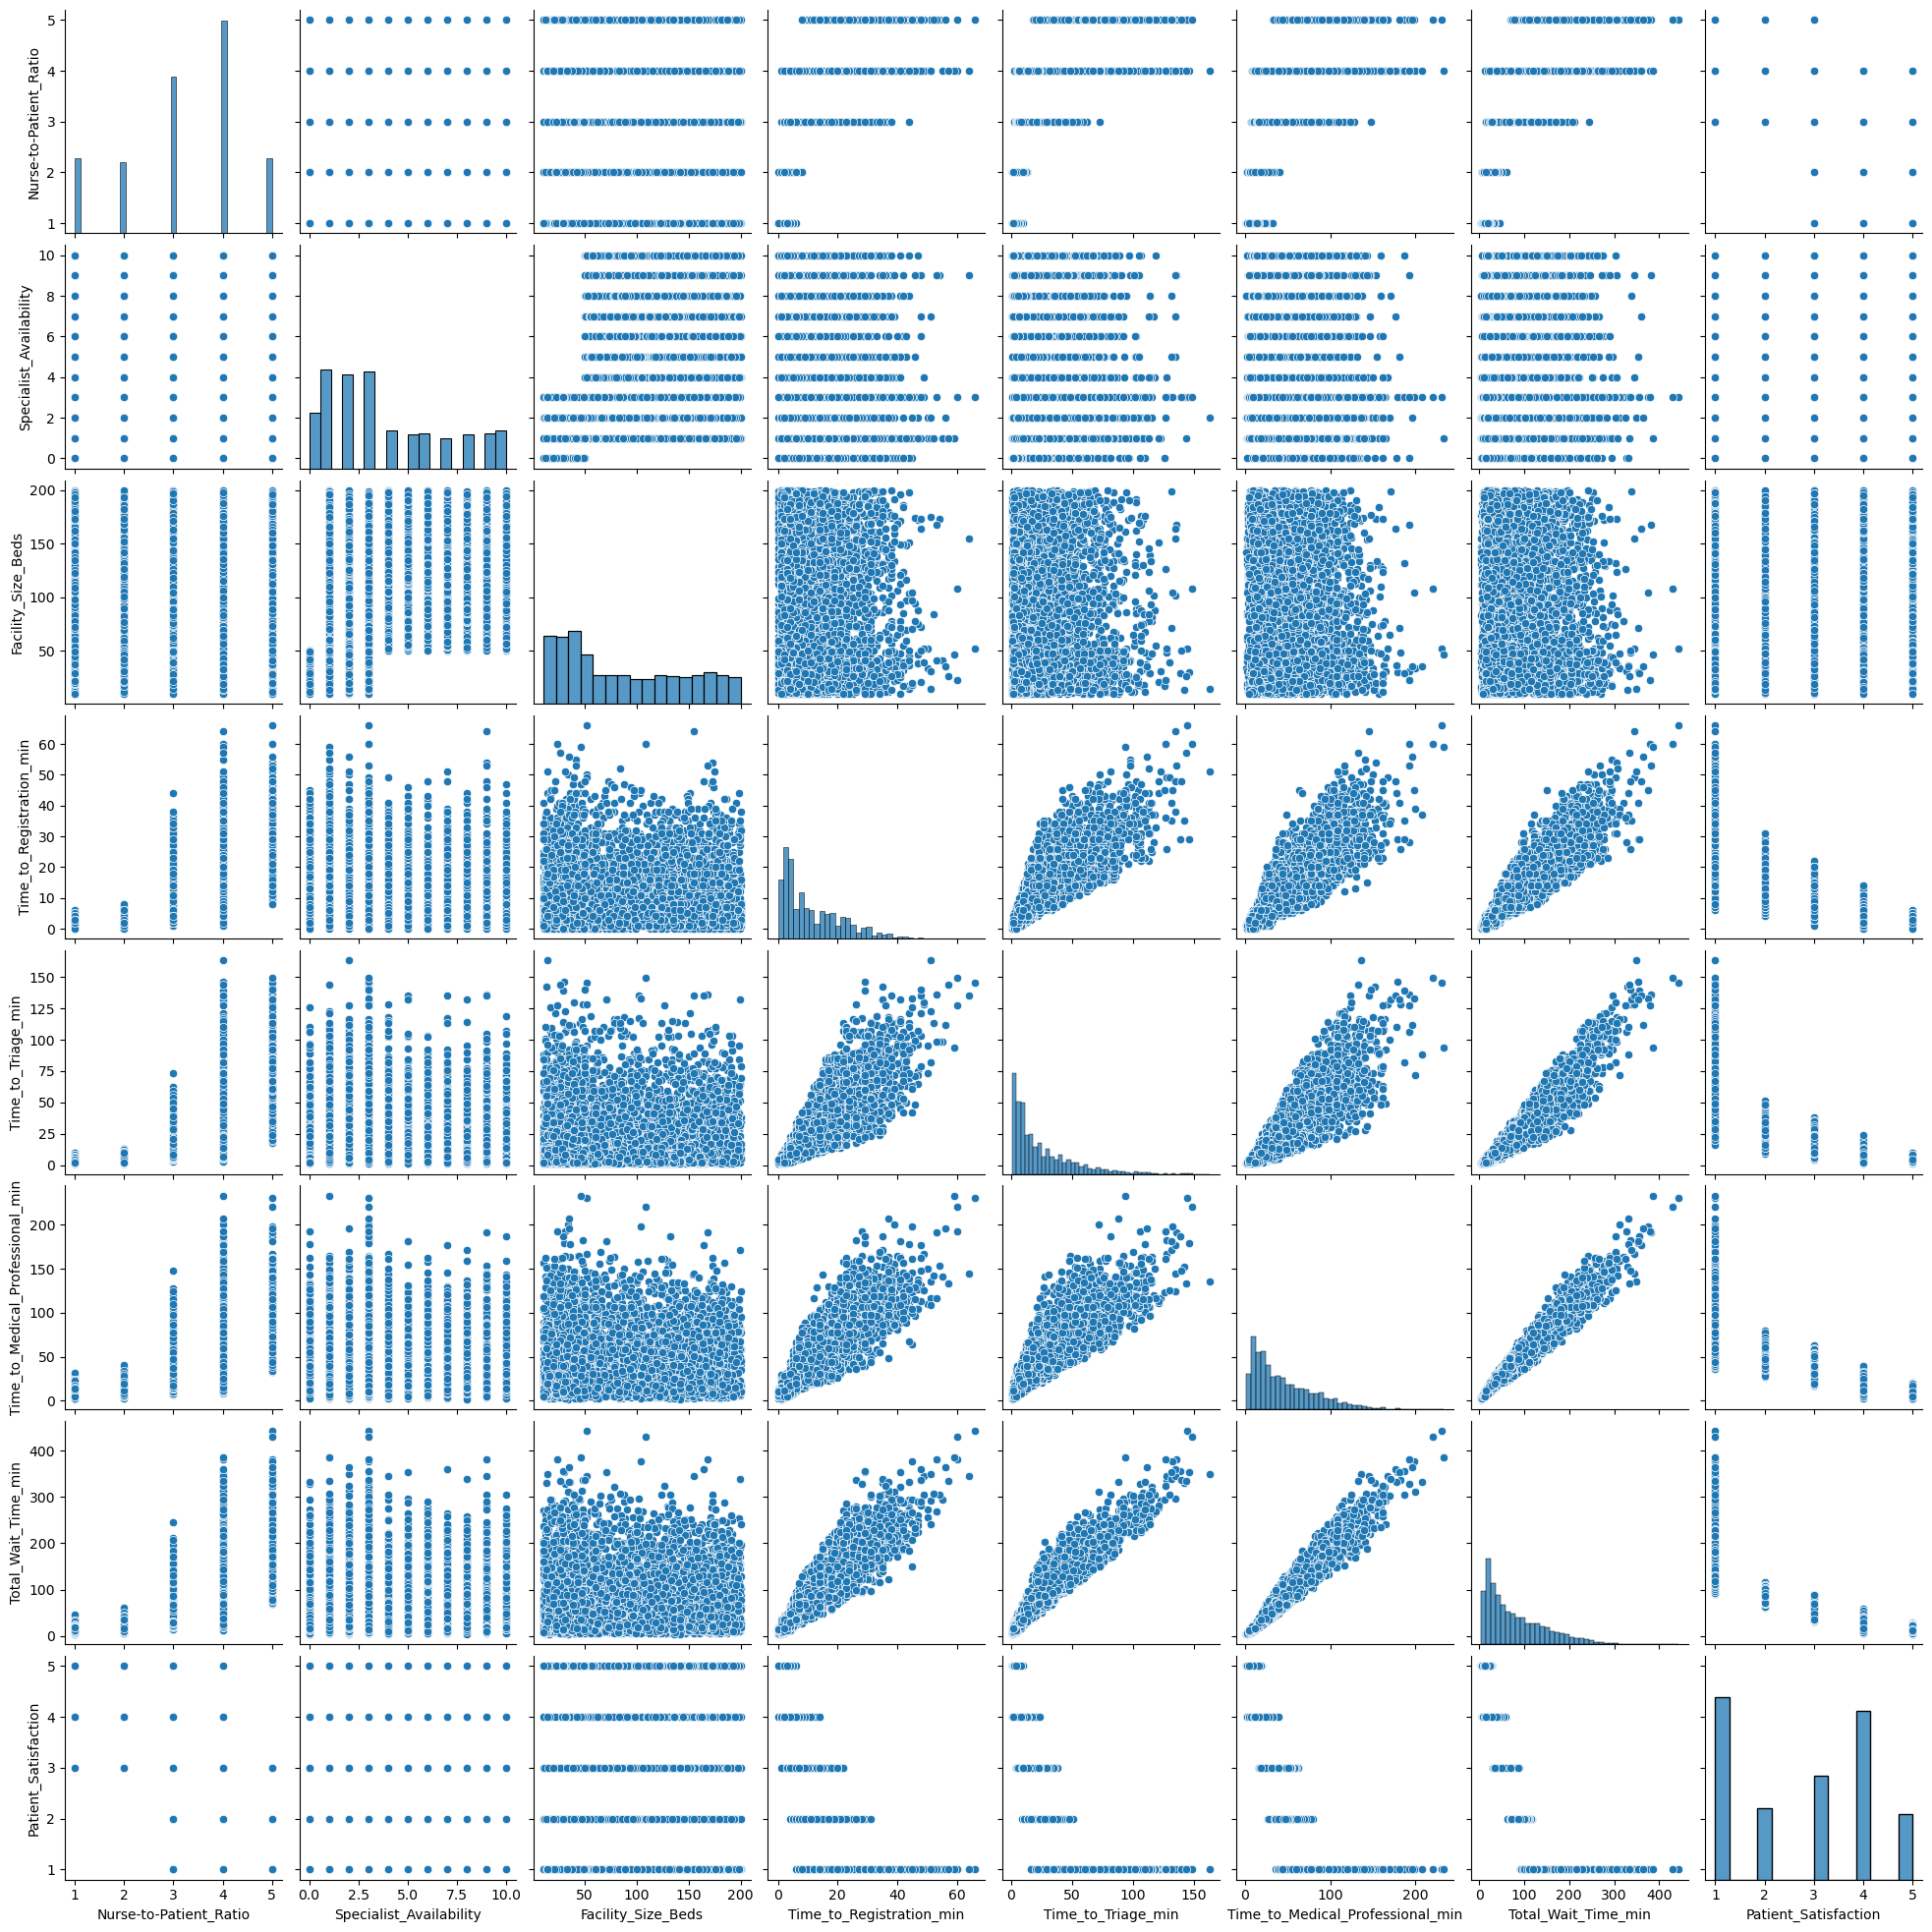

In [11]:
#visualize data to see if any outliers
sns.pairplot(ER)

<Axes: >

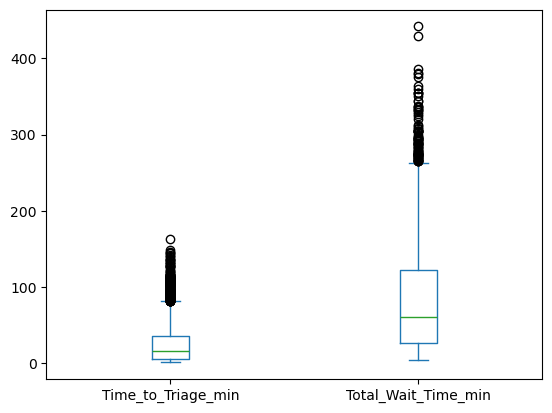

In [12]:
#create a box plot to visualize data and identify outliers 
ER[["Time_to_Triage_min", "Total_Wait_Time_min"]].plot(kind = "box")

In [13]:
#Eliminate top two data points from dataset
outliers = list(ER.Total_Wait_Time_min.sort_values()[-2:].index) #sorts values in ascending order so we can isolate the top two values
ER = ER.drop(outliers)  


2. Generate train/test sets

In [14]:
#For the first model iteration, I am leaving all the features in and then will remove features in the future as needed
#after seeing first model had an oob_score of 0.98 which was too high, I realized I had to take out the features "time to triage", "time to registration", "time to medical professional" because they contributed to the overall wait time and this information wouldnt be known beforehand
#This brought the oob_score down to 0.84
#Next I removed "Visit_Date" because the other features "Day_of_week", "Season", and "Time_of_Day" already cover it
#This brought the oob_score up to 0.85
y = ER.Total_Wait_Time_min
X = ER[['Region', 'Day_of_Week', 'Season', 'Time_of_Day', 'Urgency_Level',
       'Nurse-to-Patient_Ratio', 'Specialist_Availability',
       'Facility_Size_Beds']]

In [15]:
#Split X and y into train/test sets
#test_size = 0.3 means 30% will be used for testing
#random_state = a random seed that keeps randomness predictable and reproducible.
#make results reproducible by setting the seed of the random number generator
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)


3. Create model and Hyper-parameter tuning

In [ ]:
#during the first iteration, had the max_samples as 100, but when changed to 200 oob_score increased to 0.88 from 0.85
#as well as MAE and RMSE also improved
#Then increased max_sample=250 and oob_score increased to 0.89
#increased max_features from 4 to 6, max_samples=400, and now oob_score is 0.90 and MAE and RSME is better too
#increased n_estimators from 500 to 1000, and now OOB score is 0.91
model = RandomForestRegressor(n_estimators=1000, max_features=6, max_samples=400, oob_score=True)
rf = model.fit(X_train, y_train)


In [22]:
print(f"OOB Score: {rf.oob_score_}")

OOB Score: 0.91108714189076


4. Variable importance

<Axes: >

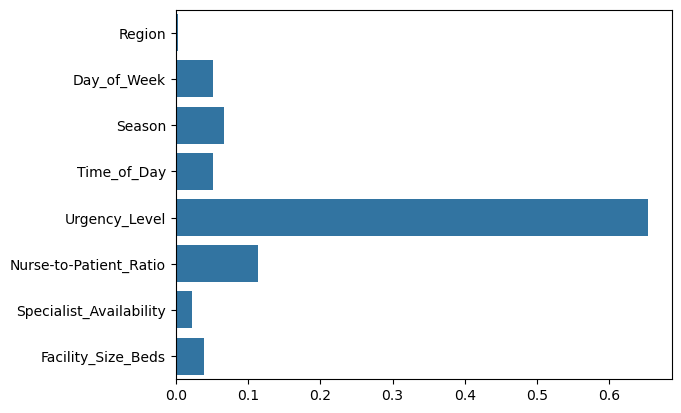

In [23]:
#shows how important each feature is to the model
sns.barplot(x = rf.feature_importances_, y = rf.feature_names_in_)

5. Model evaluation

In [24]:
pred_time = rf.predict(X_test)
y_test

84       11
2472     25
2805    163
4988     36
4925     74
       ... 
2341     41
1836     12
4545     13
4437     95
1147     41
Name: Total_Wait_Time_min, Length: 1500, dtype: int64

In [25]:
#Regression metrics
mae = mean_absolute_error(y_true=y_test, y_pred=pred_time)
print(f"MAE:{mae}")

mse = mean_squared_error(y_true=y_test, y_pred=pred_time)
rmse = math.sqrt(mse)
print(f"RMSE: {rmse}")

MAE:13.866929555555553
RMSE: 20.228304875223728
